# Spacial Analysis of Cheyanne, Wyoming and the number of SNAP Households
We wanted to conduct a spacial analysis on Wyoming, the state we discovered has the least SNAP enrollment, so that we could compare our results to that of the state with the highest SNAP enrollment. In this data analysis, we will look strictly at the households that are enrolled in SNAP and see if there are siginificant areas that have more dense populations. Ethan worked on the analysis of Cheyanne,Wyoming.

## Import Libraries

In [1]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [9]:
# to illustrate, bring in tracts
gdf = gpd.read_file('cheyanne census tract.geojson')

In [10]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             20 non-null     object  
 1   name              20 non-null     object  
 2   B22003001         20 non-null     float64 
 3   B22003001, Error  20 non-null     float64 
 4   B22003002         20 non-null     float64 
 5   B22003002, Error  20 non-null     float64 
 6   B22003003         20 non-null     float64 
 7   B22003003, Error  20 non-null     float64 
 8   B22003004         20 non-null     float64 
 9   B22003004, Error  20 non-null     float64 
 10  B22003005         20 non-null     float64 
 11  B22003005, Error  20 non-null     float64 
 12  B22003006         20 non-null     float64 
 13  B22003006, Error  20 non-null     float64 
 14  B22003007         20 non-null     float64 
 15  B22003007, Error  20 non-null     float64 
 16  geometry          20

In [11]:
gdf.head()

,geoid,name,B22003001,"B22003001, Error",B22003002,"B22003002, Error",B22003003,"B22003003, Error",B22003004,"B22003004, Error",B22003005,"B22003005, Error",B22003006,"B22003006, Error",B22003007,"B22003007, Error",geometry
0,14000US56021000200,"Census Tract 2, Laramie, WY",2081.0,200.0,391.0,172.0,212.0,129.0,179.0,126.0,1690.0,250.0,176.0,96.0,1514.0,231.0,"MULTIPOLYGON (((-104.85111 41.11822, -104.8508..."
1,14000US56021000300,"Census Tract 3, Laramie, WY",1432.0,84.0,134.0,82.0,114.0,80.0,20.0,21.0,1298.0,110.0,131.0,66.0,1167.0,98.0,"MULTIPOLYGON (((-104.85098 41.11389, -104.8507..."
2,14000US56021000401,"Census Tract 4.01, Laramie, WY",1815.0,143.0,354.0,93.0,136.0,66.0,218.0,89.0,1461.0,131.0,83.0,51.0,1378.0,133.0,"MULTIPOLYGON (((-104.83821 41.08343, -104.8381..."
3,14000US56021000402,"Census Tract 4.02, Laramie, WY",2513.0,198.0,315.0,143.0,80.0,84.0,235.0,122.0,2198.0,251.0,329.0,159.0,1869.0,246.0,"MULTIPOLYGON (((-104.80957 41.09514, -104.8095..."
4,14000US56021000501,"Census Tract 5.01, Laramie, WY",2996.0,157.0,211.0,110.0,110.0,86.0,101.0,77.0,2785.0,183.0,120.0,69.0,2665.0,176.0,"MULTIPOLYGON (((-104.79471 41.13299, -104.7944..."


## Cleaning up the Data
We have to clean the data so that it only contains the values we will use in the analysis. In hindsight, I could have elimitated many more columns for the sake of cleanliness, since they were not used throughout this entire process. 

In [12]:
# trim the data to the bare minimum columns
gdf = gdf[['geoid','B22003001','B22003002','B22003003','B22003004','B22003005','B22003006','B22003007','geometry']]

# rename the columns
gdf.columns = ['geoid','TotalPop','Household received Food Stamps/SNAP','Receive SNAP, Income below poverty level','Receive SNAP, Income at or above poverty level','Household did not receive Food Stamps/SNAP','No SNAP, Income below poverty level','No SNAP, Income at or above poverty level','geometry']

In [13]:
gdf.tail()

,geoid,TotalPop,Household received Food Stamps/SNAP,"Receive SNAP, Income below poverty level","Receive SNAP, Income at or above poverty level",Household did not receive Food Stamps/SNAP,"No SNAP, Income below poverty level","No SNAP, Income at or above poverty level",geometry
15,14000US56021001502,2305.0,135.0,102.0,33.0,2170.0,226.0,1944.0,"MULTIPOLYGON (((-104.77109 41.14764, -104.7710..."
16,14000US56021001902,1658.0,87.0,58.0,29.0,1571.0,69.0,1502.0,"MULTIPOLYGON (((-105.28068 41.32145, -105.2806..."
17,14000US56021002000,3509.0,105.0,39.0,66.0,3404.0,179.0,3225.0,"MULTIPOLYGON (((-104.79997 41.08012, -104.7998..."
18,14000US56021980801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-104.82877 41.16342, -104.8287..."
19,16000US5613900,27344.0,1752.0,887.0,865.0,25592.0,1958.0,23634.0,"MULTIPOLYGON (((-104.79523 41.17735, -104.7942..."


In [14]:
gdf=gdf.drop(19)

In [15]:
#adjust the geoid's
gdf['geoid'] = gdf['geoid'].str.replace('14000US','')
gdf.tail()

,geoid,TotalPop,Household received Food Stamps/SNAP,"Receive SNAP, Income below poverty level","Receive SNAP, Income at or above poverty level",Household did not receive Food Stamps/SNAP,"No SNAP, Income below poverty level","No SNAP, Income at or above poverty level",geometry
14,56021001501,2247.0,37.0,0.0,37.0,2210.0,105.0,2105.0,"MULTIPOLYGON (((-104.76831 41.15939, -104.7683..."
15,56021001502,2305.0,135.0,102.0,33.0,2170.0,226.0,1944.0,"MULTIPOLYGON (((-104.77109 41.14764, -104.7710..."
16,56021001902,1658.0,87.0,58.0,29.0,1571.0,69.0,1502.0,"MULTIPOLYGON (((-105.28068 41.32145, -105.2806..."
17,56021002000,3509.0,105.0,39.0,66.0,3404.0,179.0,3225.0,"MULTIPOLYGON (((-104.79997 41.08012, -104.7998..."
18,56021980801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-104.82877 41.16342, -104.8287..."


In [16]:
gdf.sort_values(by='TotalPop').head(20)

,geoid,TotalPop,Household received Food Stamps/SNAP,"Receive SNAP, Income below poverty level","Receive SNAP, Income at or above poverty level",Household did not receive Food Stamps/SNAP,"No SNAP, Income below poverty level","No SNAP, Income at or above poverty level",geometry
18,56021980801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-104.82877 41.16342, -104.8287..."
7,56021000800,807.0,35.0,13.0,22.0,772.0,47.0,725.0,"MULTIPOLYGON (((-104.80930 41.14624, -104.8092..."
13,56021001402,1052.0,68.0,40.0,28.0,984.0,41.0,943.0,"MULTIPOLYGON (((-104.80917 41.16034, -104.8091..."
8,56021000900,1334.0,39.0,15.0,24.0,1295.0,79.0,1216.0,"MULTIPOLYGON (((-104.85268 41.16007, -104.8526..."
1,56021000300,1432.0,134.0,114.0,20.0,1298.0,131.0,1167.0,"MULTIPOLYGON (((-104.85098 41.11389, -104.8507..."
9,56021001000,1466.0,67.0,26.0,41.0,1399.0,98.0,1301.0,"MULTIPOLYGON (((-104.84490 41.13906, -104.8448..."
12,56021001401,1589.0,92.0,45.0,47.0,1497.0,10.0,1487.0,"MULTIPOLYGON (((-104.79003 41.14753, -104.7899..."
16,56021001902,1658.0,87.0,58.0,29.0,1571.0,69.0,1502.0,"MULTIPOLYGON (((-105.28068 41.32145, -105.2806..."
2,56021000401,1815.0,354.0,136.0,218.0,1461.0,83.0,1378.0,"MULTIPOLYGON (((-104.83821 41.08343, -104.8381..."
10,56021001200,2017.0,29.0,15.0,14.0,1988.0,68.0,1920.0,"MULTIPOLYGON (((-104.84774 41.17616, -104.8477..."


In [17]:
#remove the row that has 0 as it will be a outlier
gdf=gdf.drop(18)
gdf.sort_values(by='TotalPop').head(20)

,geoid,TotalPop,Household received Food Stamps/SNAP,"Receive SNAP, Income below poverty level","Receive SNAP, Income at or above poverty level",Household did not receive Food Stamps/SNAP,"No SNAP, Income below poverty level","No SNAP, Income at or above poverty level",geometry
7,56021000800,807.0,35.0,13.0,22.0,772.0,47.0,725.0,"MULTIPOLYGON (((-104.80930 41.14624, -104.8092..."
13,56021001402,1052.0,68.0,40.0,28.0,984.0,41.0,943.0,"MULTIPOLYGON (((-104.80917 41.16034, -104.8091..."
8,56021000900,1334.0,39.0,15.0,24.0,1295.0,79.0,1216.0,"MULTIPOLYGON (((-104.85268 41.16007, -104.8526..."
1,56021000300,1432.0,134.0,114.0,20.0,1298.0,131.0,1167.0,"MULTIPOLYGON (((-104.85098 41.11389, -104.8507..."
9,56021001000,1466.0,67.0,26.0,41.0,1399.0,98.0,1301.0,"MULTIPOLYGON (((-104.84490 41.13906, -104.8448..."
12,56021001401,1589.0,92.0,45.0,47.0,1497.0,10.0,1487.0,"MULTIPOLYGON (((-104.79003 41.14753, -104.7899..."
16,56021001902,1658.0,87.0,58.0,29.0,1571.0,69.0,1502.0,"MULTIPOLYGON (((-105.28068 41.32145, -105.2806..."
2,56021000401,1815.0,354.0,136.0,218.0,1461.0,83.0,1378.0,"MULTIPOLYGON (((-104.83821 41.08343, -104.8381..."
10,56021001200,2017.0,29.0,15.0,14.0,1988.0,68.0,1920.0,"MULTIPOLYGON (((-104.84774 41.17616, -104.8477..."
6,56021000700,2026.0,227.0,82.0,145.0,1799.0,303.0,1496.0,"MULTIPOLYGON (((-104.85113 41.11916, -104.8511..."


In [18]:
gdf = gdf.to_crs(epsg=3857)

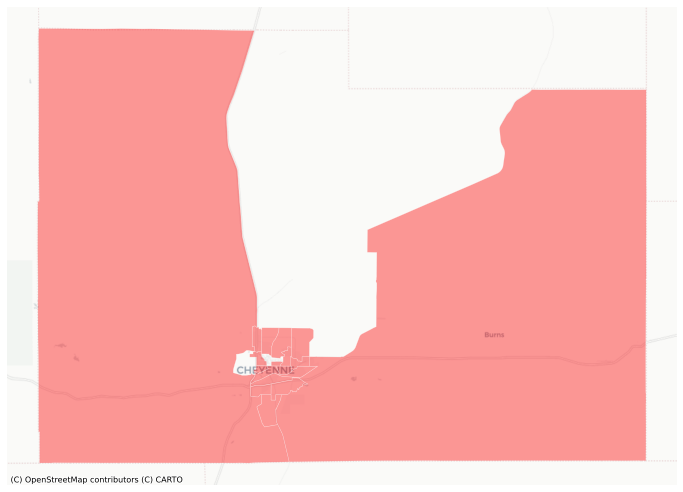

In [19]:
fig, ax = plt.subplots(figsize=(12,12))

gdf.plot(ax=ax,
         color='red', 
         edgecolor='white',
         lw=0.5,
         alpha=0.4)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

This is amap of the census block, so that we have an idea of what area we will be analyzing. This may need to be zoomed in some more toward the center of Cheyanne.

In [32]:
gdf['SNAP_per_1000'] = gdf['Household received Food Stamps/SNAP']/gdf['TotalPop']*1000

this aims to normalize the data in order to have the most consistent and accurate results.

In [33]:
gdf.sort_values(by="SNAP_per_1000").tail()

,geoid,TotalPop,Household received Food Stamps/SNAP,"Receive SNAP, Income below poverty level","Receive SNAP, Income at or above poverty level",Household did not receive Food Stamps/SNAP,"No SNAP, Income below poverty level","No SNAP, Income at or above poverty level",geometry,Household received Food Stamps/SNAP_per_1000,Household received Food Stamps/SNAP_per_1000_lag,SNAP_per_1000
1,56021000300,1432.0,134.0,114.0,20.0,1298.0,131.0,1167.0,"MULTIPOLYGON (((-11671957.591 5029154.954, -11...",93.575419,98.539293,93.575419
6,56021000700,2026.0,227.0,82.0,145.0,1799.0,303.0,1496.0,"MULTIPOLYGON (((-11671973.955 5029933.656, -11...",112.043435,79.087882,112.043435
3,56021000402,2513.0,315.0,80.0,235.0,2198.0,329.0,1869.0,"MULTIPOLYGON (((-11667347.629 5026384.641, -11...",125.348189,101.324896,125.348189
0,56021000200,2081.0,391.0,212.0,179.0,1690.0,176.0,1514.0,"MULTIPOLYGON (((-11671971.618 5029794.608, -11...",187.890437,69.607007,187.890437
2,56021000401,1815.0,354.0,136.0,218.0,1461.0,83.0,1378.0,"MULTIPOLYGON (((-11670535.708 5024655.664, -11...",195.041322,91.005037,195.041322


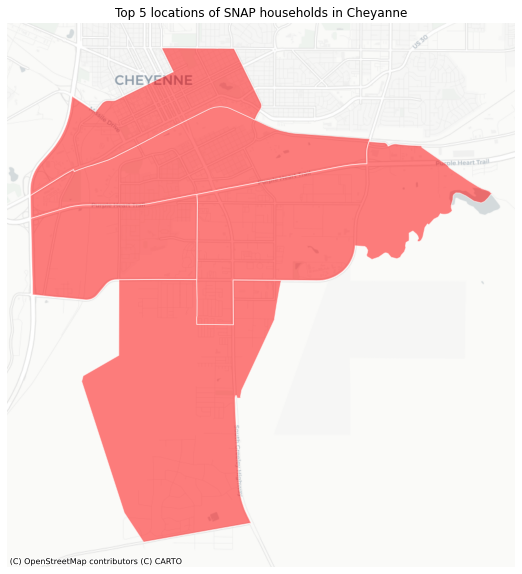

In [34]:
# map the top 20 geographies
fig,ax = plt.subplots(figsize=(12,10))
gdf.sort_values(by='SNAP_per_1000',ascending=False)[:5].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('Top 5 locations of SNAP households in Cheyanne')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

When restricting the map to the census tracts that have the top 5 locations that use SNAP, we see that it is significantly clustered in a specific area and is zoomed in more than before. 

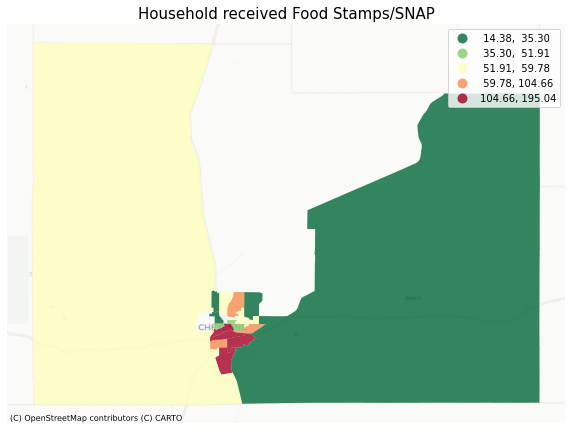

In [51]:
fig,ax = plt.subplots(figsize=(10,10))

gdf.plot(ax=ax,
        column='SNAP_per_1000',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles')

ax.axis('off')
ax.set_title('Household received Food Stamps/SNAP',fontsize=15)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

This map shows the density of SNAP users in different regions of Cheyanne, Wyoming. It is color coded based on the density of users, and the respective legend is listed at the top right for easy reference. The red areas show higher percentages of households using SNAP, and they are congregated at the center or south of downtown Cheyanne. Thus, leaving us to question why.

In [24]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(gdf,k=8)

# Row-standardization
wq.transform = 'r'

## Spatial Lag

In [37]:
gdf['SNAP_per_1000_lag'] = lps.weights.lag_spatial(wq, gdf['SNAP_per_1000'])

In [39]:
gdf.sample(10)[['TotalPop','Household received Food Stamps/SNAP','SNAP_per_1000','SNAP_per_1000_lag']]

,TotalPop,Household received Food Stamps/SNAP,SNAP_per_1000,SNAP_per_1000_lag
16,1658.0,87.0,52.472859,52.720953
15,2305.0,135.0,58.568330,76.965260
11,3688.0,201.0,54.501085,40.171498
12,1589.0,92.0,57.898049,58.712282
14,2247.0,37.0,16.466400,51.683033
7,807.0,35.0,43.370508,75.707436
8,1334.0,39.0,29.235382,71.525889
10,2017.0,29.0,14.377789,57.134039
2,1815.0,354.0,195.041322,91.005037
0,2081.0,391.0,187.890437,69.607007


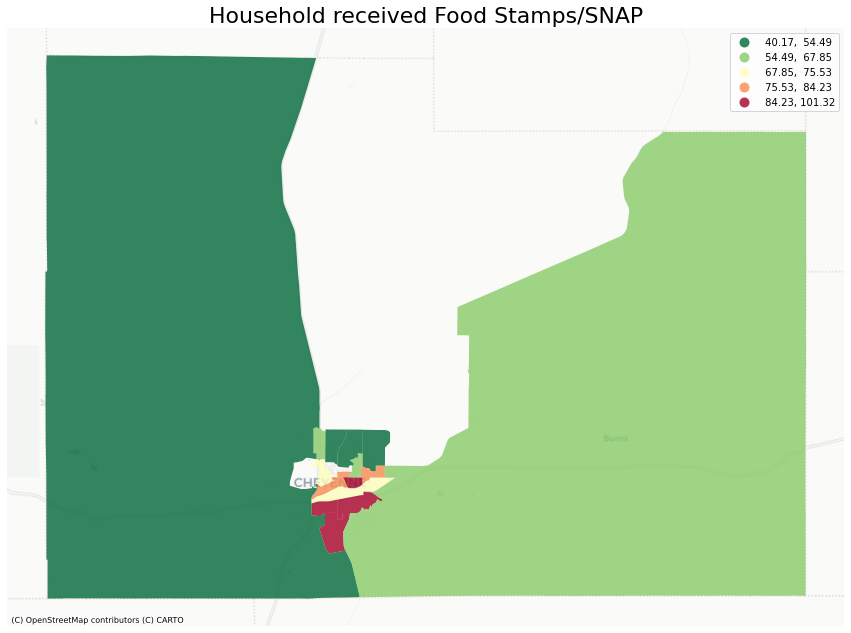

In [40]:
fig,ax = plt.subplots(figsize=(15,15))


gdf.plot(ax=ax,
        column='SNAP_per_1000_lag',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles')

ax.axis('off')
ax.set_title('Household received Food Stamps/SNAP',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

This spatial lag map demonstrates similar results as the previous map. This confirms that there is a higher concentrations of people who use snap at the heart of Cheyanne. In other areas, they are generally surrounded by low SNAP usage areas. 

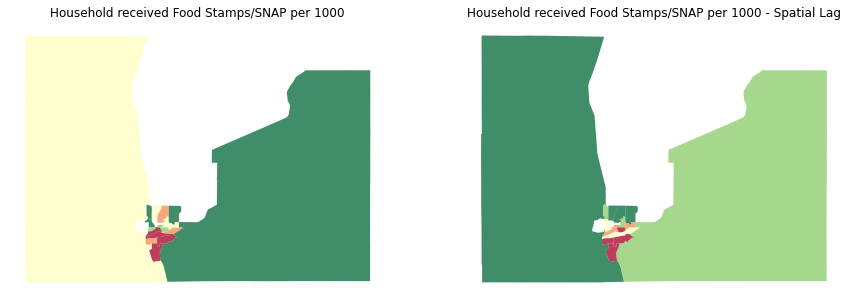

In [41]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
gdf.plot(ax=ax[0], # this assigns the map to the left subplot
         column='SNAP_per_1000', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Household received Food Stamps/SNAP per 1000")

# spatial lag map on the right
gdf.plot(ax=ax[1], # this assigns the map to the right subplot
         column='SNAP_per_1000_lag', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Household received Food Stamps/SNAP per 1000 - Spatial Lag")

plt.show()

This is a direct comparison between the two maps in order for more efficent and easy comparison. Generally, the high SNAP usage remains in the same area.

In [42]:
y = gdf.SNAP_per_1000
moran = Moran(y, wq)
moran.I

0.16630893359510818

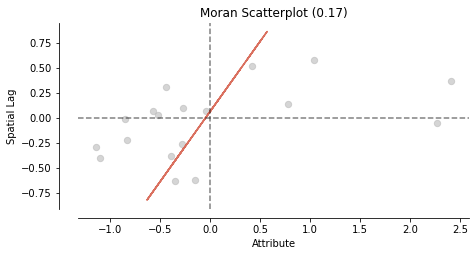

In [43]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:47: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:48: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f26ac47fb20>)

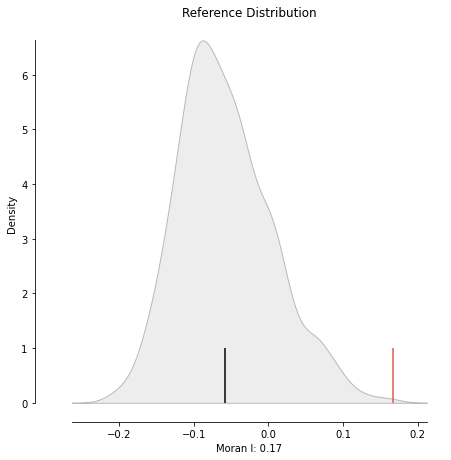

In [44]:
plot_moran_simulation(moran,aspect_equal=False)

In [45]:
moran.p_sim

0.001

In [46]:
lisa = esda.moran.Moran_Local(y, wq)

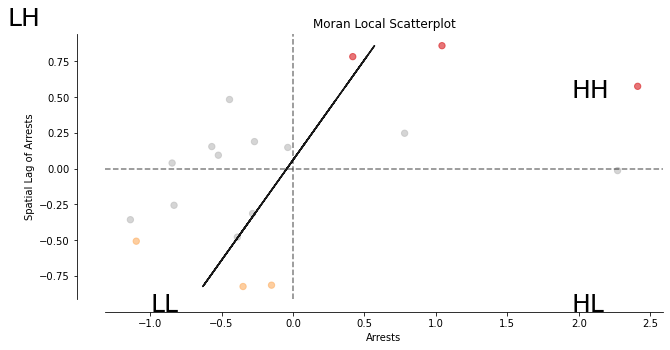

In [47]:
# Plot
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Arrests")
ax.set_ylabel('Spatial Lag of Arrests')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

Overall, there are not many points, and it can be hard to determine a strong correlation with amount of data values collected. Genreally, there are only significant areas of high SNAP usage areas being surrounded by other high SNAP usage areas and low surrounded by other low SNAP usage areas. This demonstrates that there is a clear division in Cheyanne between people who use SNAP and those who don't. This can imply a clear physical separation between the wealthy, and those who barely make enough money to provide for their own basic needs. 

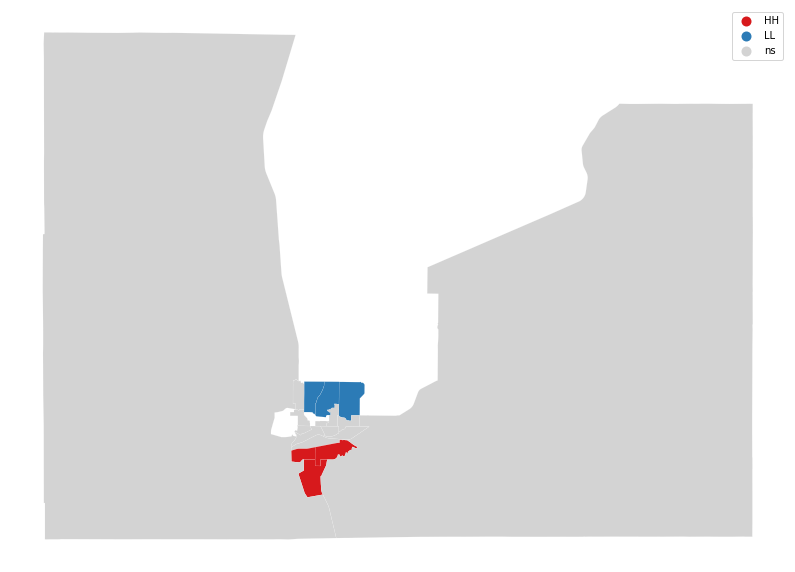

In [48]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf, p=0.05, ax=ax)
plt.show()

This map shows the areas that are statistically significant clusters of areas that have high SNAP surrounded by similar areas. It is the same for areas with low SNAP. In the center of the city, there is a clear division between north and south and that can demonstrate an uneven distribution of resources and wealth. This also shows that people with SNAP congregate together, just as those who dont have SNAP congregate together.

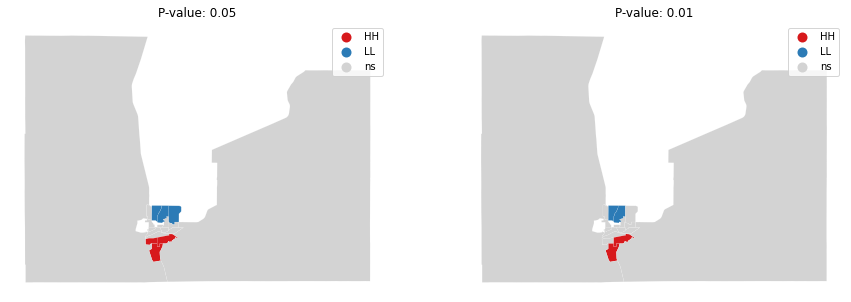

In [49]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# regular count map on the left
lisa_cluster(lisa, gdf, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, gdf, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

This chart shows the difference in maps when looking at different p-values, showing which areas are even more statistically significant. The little change is very telling of just how stark the difference is between the North and the South of Cheyanne are financially.